In [0]:
# Imports

import pickle
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Text to vector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

#Dimensionality reduction
from sklearn.decomposition import TruncatedSVD

#others
from tqdm import tqdm_notebook

In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 2.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=e56142494ab8fad467f3fac0b78aa2634b92bb573d3661b0439dd05146c45d17
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure

In [4]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"vinodkumar9576","key":"af074010bd4c7bb75f9d1fe71f31452d"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c quora-question-pairs

# To find the list of file names in zip file
#for name in zip_file.namelist():
#    print ('%s' % (name))
#zip_file.close()

#Found this code snipper for reading files in a zipfile within a zipfile.
#https://stackoverflow.com/questions/11930515/unzip-nested-zip-files-in-python?noredirect=1&lq=1

import zipfile
from io import BytesIO
import re

with zipfile.ZipFile('/content/quora-question-pairs.zip', "r") as z:
  with z.open('train.csv.zip') as z2:
    z2_filedata = BytesIO(z2.read())
    with zipfile.ZipFile(z2_filedata) as nested_zip:
      qstns_train = pd.read_csv(nested_zip.open('train.csv'))
  with z.open('test.csv.zip') as z3:
    z3_filedata = BytesIO(z3.read())
    with zipfile.ZipFile(z3_filedata) as nested_zip2:
      qstns_test = pd.read_csv(nested_zip2.open('test.csv'),dtype = {"test_id":object,"question1":object,"question2":object})

print("qstns_train :",end='\n')
print(qstns_train.head(2))
print("qstns_test :",end='\n')
print(qstns_test.head(2))

mkdir: cannot create directory ‘/root/.kaggle’: File exists
quora-question-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)
qstns_train :
   id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0

[2 rows x 6 columns]
qstns_test :
  test_id  ...                                          question2
0       0  ...  Why did Microsoft choose core m3 and not core ...
1       1  ...        How much cost does hair transplant require?

[2 rows x 3 columns]


In [5]:
print(qstns_train['question1'][341])

Earthquake resistant homes?


* **For performance metrics we use log-loss and Binary Confusion matrix**

## Train and Test Construction

* We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

<h1>3. Exploratory Data Analysis </h1>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [0]:
print("size of train: ",qstns_train.shape, end='\n')
print("size of test: ",qstns_test.shape, end='\n')

size of train:  (404290, 6)
size of test:  (3563475, 3)


In [0]:
qstns_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
qstns_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

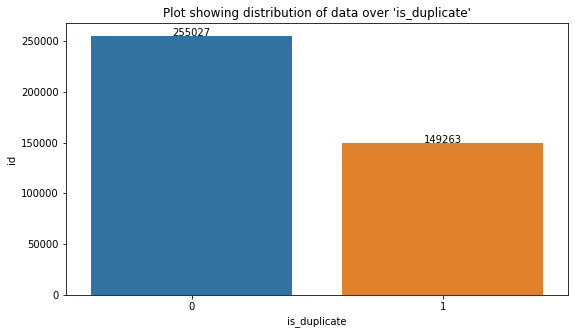

In [0]:
groupedval = qstns_train.groupby('is_duplicate')['id'].count().reset_index()

plt.figure(figsize=(9,5))
plt.title("Plot showing distribution of data over \'is_duplicate\'")
p = sns.barplot(x='is_duplicate',y='id',data = groupedval)

for index, row in groupedval.iterrows():
  p.text(row.name,row.id,row.id,color='black',ha='center')

plt.show()

In [0]:
groupedval.head()

,is_duplicate,id
0,0,255027
1,1,149263


In [0]:
print("Total no. of question pairs for training : {}".format(len(qstns_train)))


Total no. of question pairs for training : 404290


In [0]:
dissim = qstns_train['is_duplicate'].value_counts()[0]/len(qstns_train)*100

sim = qstns_train['is_duplicate'].value_counts()[1]/len(qstns_train)*100

print("% of question pairs are not similar (is_duplicate=0) : {}".format(round(dissim,2)))

print("% of question pairs are similar (is_duplicate=1) : {}".format(round(sim,2)))

% of question pairs are not similar (is_duplicate=0) : 63.08
% of question pairs are similar (is_duplicate=1) : 36.92


<h3> 3.2.2 Number of unique questions </h3>

* For this we join, question1, question2 column and count uniques.

In [0]:
tot_qstns = pd.Series(qstns_train['qid1'].tolist() + qstns_train['qid2'].tolist())

uniq_qstns = len(np.unique(tot_qstns))
dup_qstns = np.sum(tot_qstns.value_counts()>1)
max_appeared_qstn = tot_qstns.value_counts().max()

print("Total num of Unique Questions are: {}".format(uniq_qstns))
print("Number of unique questions that appear more than one time: {} and its % : {}".format(dup_qstns, round(dup_qstns/uniq_qstns*100,2)))
print("Max number of times a single question is repeated: {}".format(max_appeared_qstn))

Total num of Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 and its % : 20.78
Max number of times a single question is repeated: 157


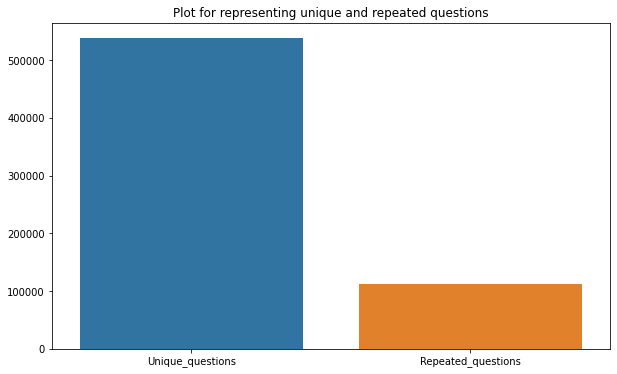

In [0]:
# Plot for representing unique and repeated questions
# Plotting with know limited values.

x = ["Unique_questions","Repeated_questions"]
y = [uniq_qstns, dup_qstns]

plt.figure(figsize=(10,6))
plt.title("Plot for representing unique and repeated questions")
p = sns.barplot(x,y)
#for index, row in y.iterrows():
#p.text(y.uniq_qstns,y.uniq_qstns,y.dup_qstns,color='black',ha='center')
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [0]:
# Checking for repeated pair of questions

pair_duplicates = qstns_train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
# what above does is grouping by qid1, qid2 and if repeations qstn pair occur, then multiple row entries
# will be existing in pair_duplicates so this row count will be more than actual qstn_train's row count.
# Also we are finding here only count of dup pair questions.
# If any duplicates occured, we'll use drop.

print("Number of duplicate questions : {}".format(pair_duplicates.shape[0]-qstns_train.shape[0]))

Number of duplicate questions : 0


<h3> 3.2.4 Number of occurrences of each question </h3>

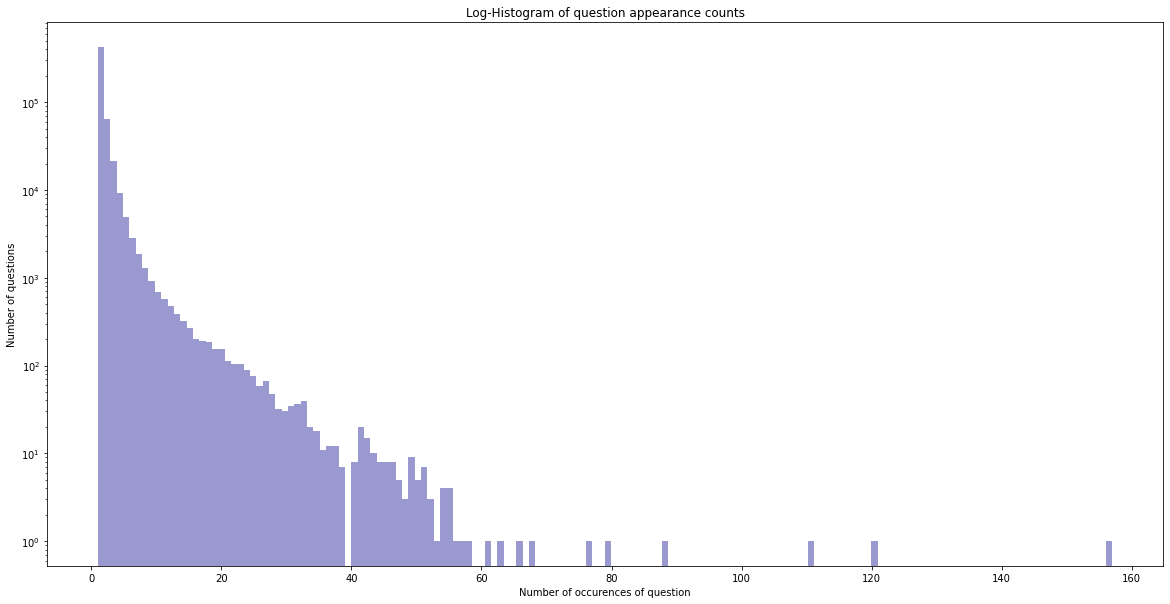

Maximum number of times a single question is repeated: 157



In [0]:
# Plotting the number of occurances of each question
tot_qstns = pd.Series(qstns_train['qid1'].tolist() + qstns_train['qid2'].tolist())

plt.figure(figsize=(20,10))
sns.distplot(tot_qstns.value_counts(),kde=False,bins=160,color = 'darkblue')
plt.yscale('log', nonposy ='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

print("Maximum number of times a single question is repeated: {}\n".format(max(tot_qstns.value_counts())))

<h3> 3.2.5 Checking for NULL values </h3>

In [0]:
# We are checkng if there are any nulls in question1 & question2
nan_rows = qstns_train[qstns_train.isnull().any(1)]

#filling the Nan values with ''
qstns_train = qstns_train.fillna('')

nan_rows = qstns_train[qstns_train.isnull().any(1)]

print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

We are constructing new features based on the given data

* **freq_qid1** = Frequency of qid1 (how many times qid1 repeated in question1 col in the training data).
* **freq_qid2** = Frequency of qid2
* **len_q1** = Length of q1
* **len_q2** = Length of q2
* **n_words_q1** = Numer of words in question 1
* **n_words_q2** = Number of words in question 2
* **words_Common** = Number of common unique words in question 1 and question 2
* **words_Total** = Total num of unique words in question 1 + question 2
* **words_Share** = (words_Common)/(words_Total)
* **freq_q1+freq_q2** = Sum of total freq of qid1 and qid2
* **freq_q1-freq_q2** = Absolute difference of frequency of qid1 and qid2

In [0]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/Models/Quora'):
  os.mkdir('/content/drive/My Drive/Colab Notebooks/Models/Quora')

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_without_preprocessing.csv'):
  qstns_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_without_preprocessing.csv',encoding = 'latin-1')

else:
  qstns_train['freq_qid1'] = qstns_train.groupby('qid1')['qid1'].transform('count')
  qstns_train['freq_qid2'] = qstns_train.groupby('qid2')['qid2'].transform('count')
  qstns_train['len_q1'] = qstns_train['question1'].str.len()
  qstns_train['len_q2'] = qstns_train['question2'].str.len()
#  def word_cnt(x):
#  cnt = len(x.split(' '))
#  return cnt
#qstns_train['question1'].transform(word_cnt)
# can use above also instead of lambda function
  qstns_train['n_words_q1'] = qstns_train['question1'].apply(lambda q1:len(q1.split(' ')))
  qstns_train['n_words_q2'] = qstns_train['question2'].apply(lambda q2:len(q2.split(' ')))
  
  # For finding unique common words we use, set and & operator
  def uniq_words(row):
    q1_w = set(map(lambda x:x.lower().strip(),row['question1'].split(' ')))
    q2_w = set(map(lambda x:x.lower().strip(), row['question2'].split(' ')))
    return (1.0) * len(q1_w & q2_w)
  
  qstns_train['words_Common'] = qstns_train.apply(uniq_words,axis=1)

  #Total number of unique words in q1+q2
  def uniq_words_sum(row):
    q1_w = set(map(lambda x:x.lower().strip(), row['question1'].split(' ')))
    q2_w = set(map(lambda x:x.lower().strip(), row['question2'].split(' ')))
    retrun (1.0) * len(q1_w)+len(q2_w)
  
  qstns_train['words_Total'] = qstns_train.apply(uniq_words,axis=1)

  #words share
  def word_share(row):
    q1_w = set(map(lambda x:x.lower().strip(),row['question1'].split(' ')))
    q2_w = set(map(lambda x:x.lower().strip(), row['question2'].split(' ')))
    return (1.0) * len(q1_w & q2_w)/(len(q1_w)+len(q2_w))
  
  qstns_train['word_Share'] = qstns_train.apply(word_share,axis = 1)

  qstns_train['freq_q1+q2'] = qstns_train['freq_qid1']+qstns_train['freq_qid2']
  qstns_train['freq_q1-q2'] = abs(qstns_train['freq_qid1']+qstns_train['freq_qid2'])

  qstns_train.to_csv('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_without_preprocessing.csv', index=False)

qstns_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,len_q1,len_q2,n_words_q1,n_words_q2,words_Common,words_Total,word_Share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,10.0,0.434783,2,2
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,4.0,0.200000,5,5
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,4.0,0.166667,2,2
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,0.0,0.000000,2,2
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,2.0,0.100000,4,4


<h3> 3.3.1 Analysis of some of the extracted features </h3>

In [0]:
min_words_1 = min(qstns_train['n_words_q1'])
min_words_2 = min(qstns_train['n_words_q2'])

print('Minimum no. of words Questions in question1 have : {} and no. of qstns {}'.format(min_words_1,qstns_train[qstns_train['n_words_q1']==1].shape[0]))
print('Maximum no. of words Questions in question2 have : {} and no. of qstns {}'.format(min_words_2,qstns_train[qstns_train['n_words_q2']==1].shape[0]))

# We'll delete all these one word questions as the sentence in english has atlease two words.


Minimum no. of words Questions in question1 have : 1 and no. of qstns 67
Maximum no. of words Questions in question2 have : 1 and no. of qstns 24


* **We are going to plot violin plot for the features against output 'is_duplicate'**

<h4> 3.3.1.1 Feature: word_share </h4>

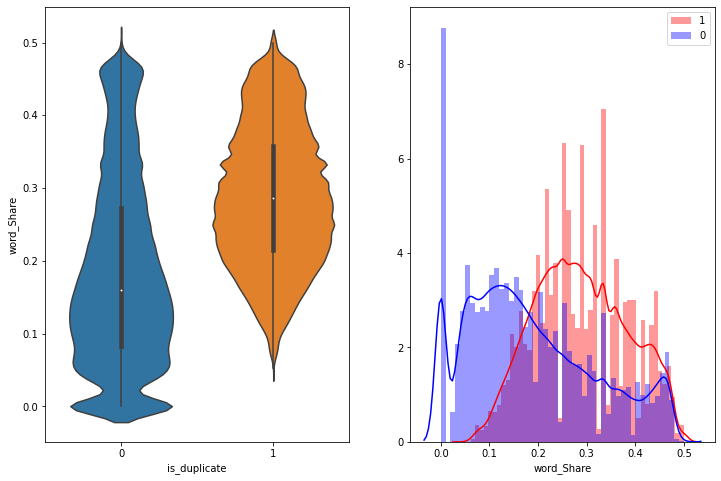

In [0]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Share',data = qstns_train)

plt.subplot(1,2,2)
sns.distplot(qstns_train[qstns_train['is_duplicate'] == 1]['word_Share'][0:], label='1', color ='red')
sns.distplot(qstns_train[qstns_train['is_duplicate'] == 0]['word_Share'][0:], label='0', color ='blue')
plt.legend()
plt.show()

* If two violin shapes are parallel in a plot, then it says those two distributions are overlapping each other. You can see from above distplot of dup=1,0.
* The average word share and Common no. of qid1 and qid2 is more when they are similar(duplicate).

<h4> 3.3.1.2 Feature: word_Common </h4>

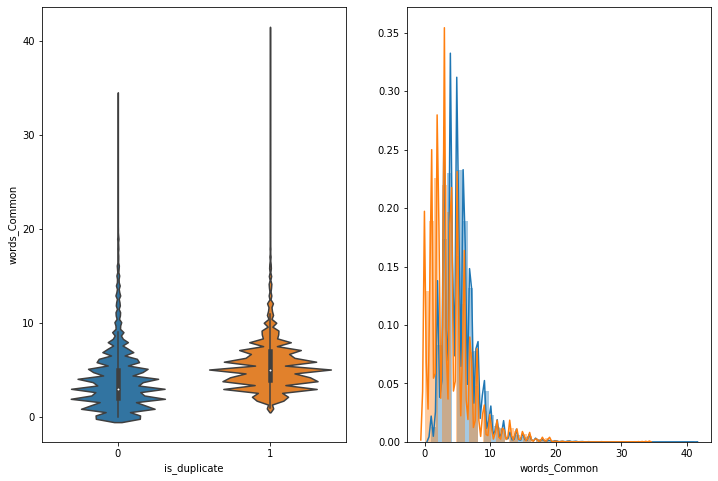

In [0]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='words_Common',data =qstns_train)

plt.subplot(1,2,2)
sns.distplot(qstns_train[qstns_train['is_duplicate']==1]['words_Common'],label='1')
sns.distplot(qstns_train[qstns_train['is_duplicate']==0]['words_Common'],label='0')
plt.legend()
plt.show()

* The distributions of the word_common of similar and dissimiliar questions are highly overlapping.